Author: Filip Bucko  
Email: xbucko05@vutbr.cz  
Institution: Brno University of Technology - Faculty of Information Technology  
Date: 18.5.2024

# Malicious Domain Detection via DNS Metadata

This notebook prepares DNS metadata records for binary classification of domains (malicious vs. benign).

## Workflow Overview

1. **DNS JSON Preprocessing**  
   Flatten and clean DNS records exported from MongoDB.

2. **Missing Value Analysis**  
   Evaluate and filter fields based on missingness patterns and statistical tests.

3. **Transformer Input Preparation**  
   Construct structured text inputs from selected DNS fields for transformer-based classification.

## Output

- A cleaned and labeled DataFrame with an `input_string` column suitable for model training.


## Phase 1: DNS JSON Preprocessing and Flattening

This phase loads raw DNS metadata exported from MongoDB and transforms it into a structured tabular format.

**Input Format:**  
A JSON Lines (`.jsonl`) file where each line contains:
- `"domain_name"`: the domain under analysis
- `"dns"`: a nested dictionary with DNS metadata

**Processing Steps:**
- Read each line of the file into memory.
- Flatten nested DNS fields using `pandas.json_normalize`.
- Drop any internal fields (e.g., `"_id"`) introduced by MongoDB.
- Remove the `"dns."` prefix from column names for clarity.

**Output:**  
A `pandas.DataFrame` where each row corresponds to a domain and columns represent flattened DNS metadata fields.


In [1]:
# Standard libraries
import json
import random
from pathlib import Path
from typing import Optional, List, Dict

# Third-party libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Jupyter-specific display utility
from IPython.display import HTML


In [4]:
def render_dataframe(df: pd.DataFrame, max_rows: int = 100, max_cols: int = 50) -> HTML:
    """
    Render a styled HTML preview of a DataFrame with limited rows and column width.
    """
    styles = [
        {"selector": "th", "props": [("max-width", "200px")]},
        {"selector": "td", "props": [("max-width", "200px"), ("overflow", "auto"), ("text-overflow", "ellipsis")]}
    ]
    return HTML(
        df.head(max_rows)
        .style.set_table_styles(styles)
        .set_table_attributes('style="display:inline-block;overflow:auto;max-height:500px;"')
        .to_html()
    )

def read_json_file(file_path: str) -> pd.DataFrame:
    """
    Load and flatten a JSONL file containing DNS metadata.

    Each line in the file should be a JSON object with a nested 'dns' field.
    """
    with open(file_path, 'r') as f:
        data = [json.loads(line) for line in f]

    df = pd.json_normalize(data, sep='.')

    # Drop MongoDB-specific metadata columns
    df = df.drop(columns=[col for col in df.columns if col.startswith('_id')], errors='ignore')

    # Standardize column names by removing the 'dns.' prefix
    df.columns = [col.replace('dns.', '') for col in df.columns]
    return df

In [5]:
def _sample_jsonl_lines(file_path: str, sample_size: int, total_lines: int, seed: int) -> List[Dict]:
    """
    Randomly sample lines from a JSONL file.

    Args:
        file_path (str): Path to the JSONL file.
        sample_size (int): Number of lines to sample.
        total_lines (int): Total number of lines in the file.
        seed (int): Random seed for reproducibility.

    Returns:
        List[Dict]: Sampled JSON objects.
    """
    random.seed(seed)
    selected_indices = set(random.sample(range(total_lines), sample_size))
    data = []

    with open(file_path, 'r') as f:
        for i, line in enumerate(f):
            if i in selected_indices:
                data.append(json.loads(line))
            if len(data) >= sample_size:
                break

    return data

def read_json_file_to_df(
    file_path: str,
    sample_size: Optional[int] = None,
    seed: int = 42,
    flatten_depth: Optional[int] = None
) -> pd.DataFrame:
    """
    Load a JSONL file and return a flattened DataFrame.

    Args:
        file_path (str): Path to the JSONL file.
        sample_size (int, optional): If provided, sample this many records.
        seed (int): Random seed for reproducibility.
        flatten_depth (int, optional): Maximum depth to flatten nested structures.

    Returns:
        pd.DataFrame: Flattened DataFrame with DNS metadata fields.
    """
    # Count lines in the file
    with open(file_path, 'r') as f:
        total_lines = sum(1 for _ in f)

    # Load data
    if sample_size is None or sample_size >= total_lines:
        with open(file_path, 'r') as f:
            data = [json.loads(line) for line in f]
    else:
        data = _sample_jsonl_lines(file_path, sample_size, total_lines, seed)

    # Flatten the JSON
    normalize_args = {'sep': '.'}
    if flatten_depth is not None:
        normalize_args['max_level'] = flatten_depth
    df = pd.json_normalize(data, **normalize_args)

    # Clean column names
    df = df.drop(columns=[col for col in df.columns if col.startswith('_id')], errors='ignore')
    df.columns = [col.replace('dns.', '') for col in df.columns]

    return df


### Benign

In [6]:
# Determine the root directory of the project
script_path = Path.cwd()
project_root = script_path.parent.parent

benign_file_path = project_root / "datasets" / "benign" / "benign_2312_anonymized_dns_2024.json"
benign_df = read_json_file_to_df(benign_file_path, sample_size=100_000, flatten_depth=1)
render_dataframe(benign_df)

,domain_name,A,AAAA,CNAME,MX,NS,TXT,SOA,zone_SOA,dnssec,remarks,sources,ttls,NAPTR
0,0000100b00e9.han2.savba.sk,['147.213.4.22'],None,None,None,None,None,None,"{'primary_ns': 'savba.savba.sk', 'resp_mailbox_dname': 'postmaster.savba.sk', 'serial': 2022332560, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 86400}","{'A': 3, 'AAAA': 3, 'SOA': 3, 'CNAME': 3, 'MX': 3, 'NS': 3, 'TXT': 3, 'NAPTR': 3}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'savba.sk'}","{'A': 0, 'AAAA': 2, 'SOA': 2, 'CNAME': 2, 'MX': 2, 'NS': 2, 'TXT': 2, 'NAPTR': 2}","{'A': 86400, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",nan
1,0000102n02c4.han2.savba.sk,['147.213.4.22'],None,None,None,None,None,None,"{'primary_ns': 'savba.savba.sk', 'resp_mailbox_dname': 'postmaster.savba.sk', 'serial': 2022332560, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 86400}","{'A': 3, 'AAAA': 3, 'SOA': 3, 'CNAME': 3, 'MX': 3, 'NS': 3, 'TXT': 3, 'NAPTR': 3}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'savba.sk'}","{'A': 0, 'AAAA': 2, 'SOA': 2, 'CNAME': 2, 'MX': 2, 'NS': 2, 'TXT': 2, 'NAPTR': 2}","{'A': 86400, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",nan
2,0000102n03d3.han2.savba.sk,['147.213.4.22'],None,None,None,None,None,None,"{'primary_ns': 'savba.savba.sk', 'resp_mailbox_dname': 'postmaster.savba.sk', 'serial': 2022332560, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 86400}","{'A': 3, 'AAAA': 3, 'SOA': 3, 'CNAME': 3, 'MX': 3, 'NS': 3, 'TXT': 3, 'NAPTR': 3}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'savba.sk'}","{'A': 0, 'AAAA': 2, 'SOA': 2, 'CNAME': 2, 'MX': 2, 'NS': 2, 'TXT': 2, 'NAPTR': 2}","{'A': 86400, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",nan
3,0000102n0434.han2.savba.sk,['147.213.4.22'],None,None,None,None,None,None,"{'primary_ns': 'savba.savba.sk', 'resp_mailbox_dname': 'postmaster.savba.sk', 'serial': 2022332560, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 86400}","{'A': 3, 'AAAA': 3, 'SOA': 3, 'CNAME': 3, 'MX': 3, 'NS': 3, 'TXT': 3, 'NAPTR': 3}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'savba.sk'}","{'A': 0, 'AAAA': 2, 'SOA': 2, 'CNAME': 2, 'MX': 2, 'NS': 2, 'TXT': 2, 'NAPTR': 2}","{'A': 86400, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",nan
4,000010560066.han2.savba.sk,['147.213.4.22'],None,None,None,None,None,None,"{'primary_ns': 'savba.savba.sk', 'resp_mailbox_dname': 'postmaster.savba.sk', 'serial': 2022332560, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 86400}","{'A': 3, 'AAAA': 3, 'SOA': 3, 'CNAME': 3, 'MX': 3, 'NS': 3, 'TXT': 3, 'NAPTR': 3}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'savba.sk'}","{'A': 0, 'AAAA': 2, 'SOA': 2, 'CNAME': 2, 'MX': 2, 'NS': 2, 'TXT': 2, 'NAPTR': 2}","{'A': 86400, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",nan
5,0000105600be.han2.savba.sk,['147.213.4.22'],None,None,None,None,None,None,"{'primary_ns': 'savba.savba.sk', 'resp_mailbox_dname': 'postmaster.savba.sk', 'serial': 2022332560, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 86400}","{'A': 3, 'AAAA': 3, 'SOA': 3, 'CNAME': 3, 'MX': 3, 'NS': 3, 'TXT': 3, 'NAPTR': 3}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'savba.sk'}","{'A': 0, 'AAAA': 2, 'SOA': 2, 'CNAME': 2, 'MX': 2, 'NS': 2, 'TXT': 2, 'NAPTR': 2}","{'A': 86400, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",nan
6,000010640021.han2.savba.sk,['147.213.4.22'],None,None,None,None,None,None,"{'primary_ns': 'savba.savba.sk', 'resp_mailbox_dname': 'postmaster.savba.sk', 'serial': 2022332560, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 86400}","{'A': 3, 'AAAA': 3, 'SOA': 3, 'CNAME': 3, 'MX': 3, 'NS': 3, 'TXT': 3, 'NAPTR': 3}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'savba.sk'}

In [8]:
# Display summary information about the benign dataset
benign_df.info()

# List all column names
benign_columns = benign_df.columns.to_list()
print("Benign DataFrame columns:")
print(benign_columns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   domain_name  100000 non-null  object
 1   A            82268 non-null   object
 2   AAAA         21560 non-null   object
 3   CNAME        10024 non-null   object
 4   MX           51973 non-null   object
 5   NS           61649 non-null   object
 6   TXT          50739 non-null   object
 7   SOA          61890 non-null   object
 8   zone_SOA     37821 non-null   object
 9   dnssec       98742 non-null   object
 10  remarks      98742 non-null   object
 11  sources      98742 non-null   object
 12  ttls         98742 non-null   object
 13  NAPTR        35 non-null      object
dtypes: object(14)
memory usage: 10.7+ MB
Benign DataFrame columns:
['domain_name', 'A', 'AAAA', 'CNAME', 'MX', 'NS', 'TXT', 'SOA', 'zone_SOA', 'dnssec', 'remarks', 'sources', 'ttls', 'NAPTR']


### Malware

In [10]:
# Resolve project root (assumes this notebook lives in /project_root/evaluation/)
project_root = Path.cwd().parent.parent

# Path to the malware RDAP JSON file
malware_file_path = project_root / "datasets" / "malware" / "malware_strict_dns_2024.json"

# Load the malware dataset with shallow flattening
malware_df = read_json_file_to_df(malware_file_path, flatten_depth=1)

# Preview
render_dataframe(malware_df)


,domain_name,A,AAAA,CNAME,MX,NS,TXT,SOA,zone_SOA,dnssec,remarks,sources,ttls
0,irradiateher.com,"['192.243.61.227', '173.233.137.60', '192.243.59.20', '192.243.61.225', '173.233.137.36', '192.243.59.13', '192.243.59.12', '173.233.137.52', '173.233.139.164', '173.233.137.44']",None,None,None,"{'ns1.publicdnsservice.com': {'related_ips': [{'ttl': 375, 'value': '23.109.170.39'}]}, 'ns4.publicdnsservice.com': {'related_ips': [{'ttl': 374, 'value': '23.109.170.199'}]}, 'ns2.publicdnsservice.com': {'related_ips': [{'ttl': 374, 'value': '23.109.170.234'}]}, 'ns3.publicdnsservice.com': {'related_ips': [{'ttl': 375, 'value': '23.109.170.139'}]}}",None,"{'primary_ns': 'ns1.publicdnsservice.com', 'resp_mailbox_dname': 'hostmaster.irradiateher.com', 'serial': 2023111904, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 3600}",None,"{'A': 3, 'AAAA': 3, 'SOA': 3, 'CNAME': 3, 'MX': 3, 'NS': 3, 'TXT': 3, 'NAPTR': 3}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'irradiateher.com'}","{'A': 0, 'AAAA': 2, 'SOA': 0, 'CNAME': 2, 'MX': 2, 'NS': 0, 'TXT': 2, 'NAPTR': 2}","{'A': 600, 'AAAA': 0, 'SOA': 3600, 'CNAME': 0, 'MX': 0, 'NS': 3600, 'TXT': 0, 'NAPTR': 0}"
1,eloquentcs.com,['50.63.8.251'],None,None,"{'smtp.secureserver.net': {'priority': 0, 'related_ips': [{'ttl': 282, 'value': '92.204.80.0'}]}, 'mailstore1.secureserver.net': {'priority': 10, 'related_ips': [{'ttl': 282, 'value': '92.204.80.3'}]}}","{'ns59.domaincontrol.com': {'related_ips': [{'ttl': 23330, 'value': '97.74.100.31'}, {'ttl': 62749, 'value': '2603:5:2143::1f'}]}, 'ns60.domaincontrol.com': {'related_ips': [{'ttl': 8928, 'value': '173.201.68.31'}, {'ttl': 55601, 'value': '2603:5:2243::1f'}]}}","['d7985274', 'v=spf1 include:secureserver.net -all']","{'primary_ns': 'ns59.domaincontrol.com', 'resp_mailbox_dname': 'dns.jomax.net', 'serial': 2023112400, 'refresh': 28800, 'retry': 7200, 'expire': 604800, 'min_ttl': 600}",None,"{'A': 3, 'AAAA': 3, 'SOA': 3, 'CNAME': 3, 'MX': 3, 'NS': 3, 'TXT': 3, 'NAPTR': 3}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'eloquentcs.com', 'has_spf': True}","{'A': 1, 'AAAA': 2, 'SOA': 1, 'CNAME': 2, 'MX': 1, 'NS': 1, 'TXT': 1, 'NAPTR': 2}","{'A': 600, 'AAAA': 0, 'SOA': 3596, 'CNAME': 0, 'MX': 3600, 'NS': 3600, 'TXT': 3600, 'NAPTR': 0}"
2,www.neutralsystemsolution.space,['35.186.223.180'],None,None,None,None,None,"{'primary_ns': 'ns1.verification-hold.suspended-domain.com', 'resp_mailbox_dname': 'admin.suspended-domain.com', 'serial': 2012022012, 'refresh': 7200, 'retry': 7200, 'expire': 172800, 'min_ttl': 7200}",None,"{'A': 3, 'AAAA': 3, 'SOA': 3, 'CNAME': 3, 'MX': 3, 'NS': 3, 'TXT': 3, 'NAPTR': 3}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'www.neutralsystemsolution.space'}","{'A': 1, 'AAAA': 2, 'SOA': 1, 'CNAME': 2, 'MX': 2, 'NS': 2, 'TXT': 2, 'NAPTR': 2}","{'A': 600, 'AAAA': 0, 'SOA': 596, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}"
3,www.drshiwanijainpainclinic.com,['5.61.57.250'],None,None,None,None,None,None,"{'primary_ns': 'ns1.dns-parking.com', 'resp_mailbox_dname': 'dns.hostinger.com', 'serial': 2024031401, 'refresh': 10000, 'retry': 2400, 'expire': 604800, 'min_ttl': 600}","{'A': 3, 'AAAA': 3, 'SOA': 3, 'CNAME': 3, 'MX': 3, 'NS': 3, 'TXT': 3, 'NAPTR': 3}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'drshiwanijainpainclinic.com'}","{'A': 0, 'AAAA': 2, 'SOA': 2, 'CNAME': 2, 'MX': 2, 'NS': 2, 'TXT': 2, 'NAPTR': 2}","{'A': 14400, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}"
4,mkt9136.com,['3.127.205.219'],None,None,"{'reply.mkt9136.com': {'priority': 10, 'related_ips': [{'ttl': 300, 'value': '18.157.127.192'}]}, 'mail8537.mkt9136.com': {'priority': 20, 'related_ips': [{'ttl': 300, 'value': '129.41.76.223'}]}}","{'ns1.acoustic-adm.com': {'related_ips': [{'ttl': 8, 'value': '205.251.197.17'}, {'ttl': 49, 'value': '2600:9000:5305:1100::1'}]}, 'ns2.acoustic-adm.com': {'related_ips': [{'ttl': 43, 'value': '205.251.198.78'},

In [11]:
malware_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100809 entries, 0 to 100808
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   domain_name  100809 non-null  object
 1   A            63099 non-null   object
 2   AAAA         15055 non-null   object
 3   CNAME        7132 non-null    object
 4   MX           29046 non-null   object
 5   NS           49414 non-null   object
 6   TXT          29025 non-null   object
 7   SOA          51760 non-null   object
 8   zone_SOA     46490 non-null   object
 9   dnssec       97715 non-null   object
 10  remarks      97715 non-null   object
 11  sources      97715 non-null   object
 12  ttls         97715 non-null   object
dtypes: object(13)
memory usage: 10.0+ MB


## Phase 2: Missing Value Analysis and Feature Filtering

This phase evaluates DNS fields for their relevance in classification, focusing on patterns of missing data across the benign and malicious datasets.

**Objective:**  
Eliminate fields that are unlikely to contribute meaningfully to a machine learning model due to excessive missing values or lack of variation between classes.

**Methodology:**
- Identify and drop columns that are entirely empty
- Quantify and visualize missingness across both datasets
- Apply statistical tests (e.g., Chi-square) to assess whether missingness correlates with the class label
- Drop fields that are both largely missing and statistically uninformative


## Handling of missing values

### Columns with any NaN (missing values)


In [12]:
# Check for columns with missing values in the benign dataset
benign_nan_columns = benign_df.columns[benign_df.isna().any()].tolist()
print("Benign Dataset:")
print(f"Columns with any missing values: {len(benign_nan_columns)}")
print(f"Total columns: {len(benign_df.columns)}")
print("---------------------------------------------------------------")

# Check for columns with missing values in the malware dataset
malware_nan_columns = malware_df.columns[malware_df.isna().any()].tolist()
print("Malware Dataset:")
print(f"Columns with any missing values: {len(malware_nan_columns)}")
print(f"Total columns: {len(malware_df.columns)}")


Benign Dataset:
Columns with any missing values: 13
Total columns: 14
---------------------------------------------------------------
Malware Dataset:
Columns with any missing values: 12
Total columns: 13


### Columns That Are Fully Empty (All Values Are NaN)
These columns can be fully dropped

In [13]:
# Identify columns in the benign dataset that are fully empty (all values are NaN)
fully_empty_benign = benign_df.columns[benign_df.isna().all()].tolist()
print("Benign Dataset:")
print(f"Fully empty columns: {fully_empty_benign}")
print("---------------------------------------------------------------")

# Identify columns in the malware dataset that are fully empty
fully_empty_malware = malware_df.columns[malware_df.isna().all()].tolist()
print("Malware Dataset:")
print(f"Fully empty columns: {fully_empty_malware}")


Benign Dataset:
Fully empty columns: []
---------------------------------------------------------------
Malware Dataset:
Fully empty columns: []


In [14]:
# Drop fully empty columns from the benign dataset
print("Benign Dataset:")
print(f"Shape before dropping: {benign_df.shape}")
benign_df.drop(columns=fully_empty_benign, inplace=True, errors="ignore")
print(f"Shape after dropping: {benign_df.shape}")
print("---------------------------------------------------------------")

# Drop fully empty columns from the malware dataset
print("Malware Dataset:")
print(f"Shape before dropping: {malware_df.shape}")
malware_df.drop(columns=fully_empty_malware, inplace=True, errors="ignore")
print(f"Shape after dropping: {malware_df.shape}")


Benign Dataset:
Shape before dropping: (100000, 14)
Shape after dropping: (100000, 14)
---------------------------------------------------------------
Malware Dataset:
Shape before dropping: (100809, 13)
Shape after dropping: (100809, 13)


In [15]:
# Display columns in the malware dataset that contain missing values
missing_counts = malware_df.isna().sum()
missing_with_values = missing_counts[missing_counts > 0]

print("Malware Dataset — Columns with Missing Values:")
print(missing_with_values)


Malware Dataset — Columns with Missing Values:
A           37710
AAAA        85754
CNAME       93677
MX          71763
NS          51395
TXT         71784
SOA         49049
zone_SOA    54319
dnssec       3094
remarks      3094
sources      3094
ttls         3094
dtype: int64


In [16]:
# Compare schema overlap between benign and malware datasets
common_columns = set(benign_df.columns) & set(malware_df.columns)
benign_only_columns = set(benign_df.columns) - set(malware_df.columns)

print(f"Number of common columns: {len(common_columns)}")
print(f"Common columns:\n{sorted(common_columns)}\n")

print(f"Number of columns only in benign dataset: {len(benign_only_columns)}")
print(f"Benign-only columns:\n{sorted(benign_only_columns)}")


Number of common columns: 13
Common columns:
['A', 'AAAA', 'CNAME', 'MX', 'NS', 'SOA', 'TXT', 'dnssec', 'domain_name', 'remarks', 'sources', 'ttls', 'zone_SOA']

Number of columns only in benign dataset: 1
Benign-only columns:
['NAPTR']


In [17]:
# Drop columns that exist only in the benign dataset to align both schemas
benign_df.drop(columns=benign_only_columns, inplace=True, errors="ignore")


In [18]:
# Display schema and non-null counts for the benign dataset
print("Benign Dataset Info:")
benign_df.info()
print("---------------------------------------------------------------")

# Display schema and non-null counts for the malware dataset
print("Malware Dataset Info:")
malware_df.info()


Benign Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   domain_name  100000 non-null  object
 1   A            82268 non-null   object
 2   AAAA         21560 non-null   object
 3   CNAME        10024 non-null   object
 4   MX           51973 non-null   object
 5   NS           61649 non-null   object
 6   TXT          50739 non-null   object
 7   SOA          61890 non-null   object
 8   zone_SOA     37821 non-null   object
 9   dnssec       98742 non-null   object
 10  remarks      98742 non-null   object
 11  sources      98742 non-null   object
 12  ttls         98742 non-null   object
dtypes: object(13)
memory usage: 9.9+ MB
---------------------------------------------------------------
Malware Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100809 entries, 0 to 100808
Data columns (total 13 columns):
 

<Figure size 1200x600 with 0 Axes>

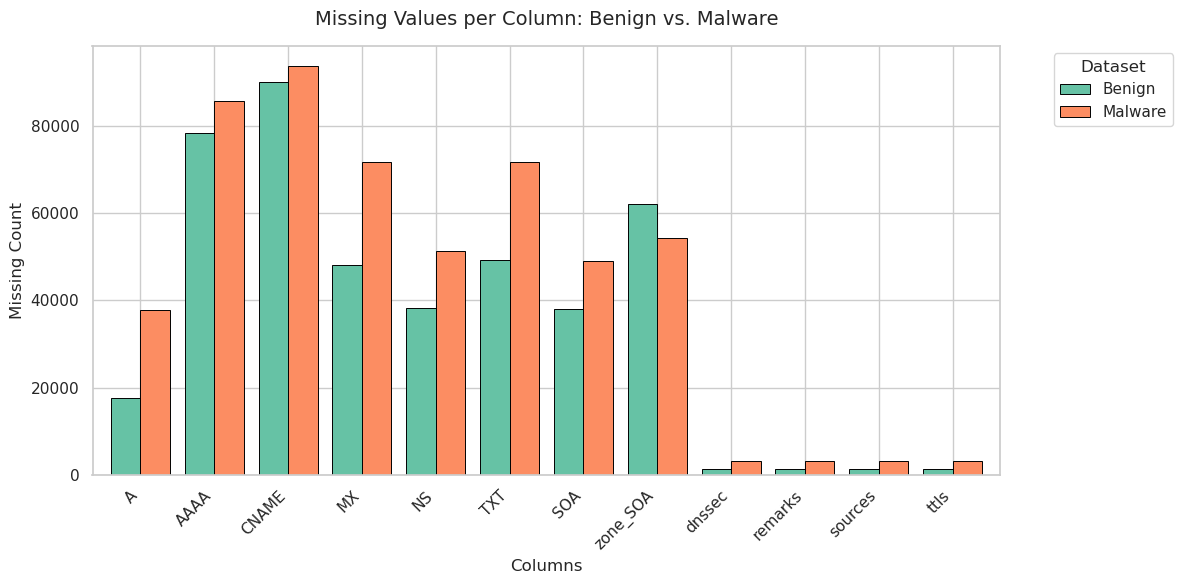

In [19]:
# Calculate total number of missing values per column for each dataset
missing_benign = benign_df.isna().sum()
missing_malware = malware_df.isna().sum()

# Combine into a single DataFrame
missing_counts = pd.DataFrame({
    'Benign': missing_benign,
    'Malware': missing_malware
})

# Filter to columns with at least one missing value in either dataset
missing_counts = missing_counts[(missing_counts['Benign'] > 0) | (missing_counts['Malware'] > 0)]

# Plot missing value counts per column
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))
colors = sns.color_palette("Set2", n_colors=2)

ax = missing_counts.plot(
    kind='bar',
    color=colors,
    width=0.8,
    edgecolor='black',
    linewidth=0.7,
    figsize=(12, 6)
)

ax.set_title("Missing Values per Column: Benign vs. Malware", fontsize=14, pad=15)
ax.set_xlabel("Columns", fontsize=12)
ax.set_ylabel("Missing Count", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

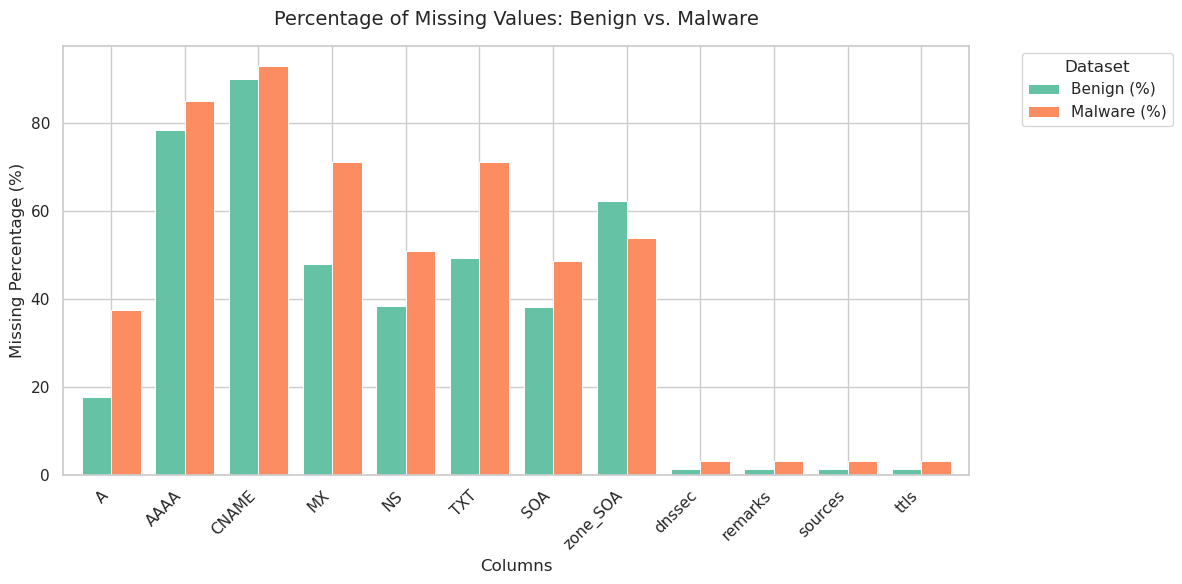

In [20]:
# Calculate the percentage of missing values per column
benign_missing_pct = benign_df.isna().mean() * 100
malware_missing_pct = malware_df.isna().mean() * 100

# Combine into a single DataFrame
missing_pct = pd.DataFrame({
    'Benign (%)': benign_missing_pct,
    'Malware (%)': malware_missing_pct
})

# Filter to columns with any missing values
missing_pct = missing_pct[(missing_pct['Benign (%)'] > 0) | (missing_pct['Malware (%)'] > 0)]

# Plot missing value percentages per column
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))
colors = sns.color_palette("Set2", n_colors=2)

ax = missing_pct.plot(
    kind='bar',
    color=colors,
    width=0.8,
    linewidth=0.7,
    figsize=(12, 6)
)

ax.set_title("Percentage of Missing Values: Benign vs. Malware", fontsize=14, pad=15)
ax.set_xlabel("Columns", fontsize=12)
ax.set_ylabel("Missing Percentage (%)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [22]:
def cohens_h(p1: float, p2: float) -> float:
    """
    Compute Cohen's h — effect size between two proportions.
    """
    return 2 * (np.arcsin(np.sqrt(p1)) - np.arcsin(np.sqrt(p2)))

# Store effect size results
effect_sizes = {}

# Compare missingness column by column
for col in benign_df.columns:
    p_benign = benign_df[col].isna().mean()
    p_malware = malware_df[col].isna().mean()
    h = abs(cohens_h(p_malware, p_benign))  # Absolute effect size

    effect_sizes[col] = {
        'Benign Missing %': p_benign * 100,
        'Malware Missing %': p_malware * 100,
        "Cohen's h": h
    }

# Create and sort a DataFrame of results
effect_df = pd.DataFrame(effect_sizes).T.sort_values("Cohen's h", ascending=False)

print("Cohen's h and missing value percentages by column:")
print(effect_df.round(3))

# Identify columns with low effect size
threshold = 0.2
features_to_drop = effect_df[effect_df["Cohen's h"] < threshold].index.tolist()

print(f"\nFeatures recommended to drop (Cohen's h < {threshold}):")
print(features_to_drop)


Cohen's h and missing value percentages by column:
             Benign Missing %  Malware Missing %  Cohen's h
MX                     48.027             71.187      0.477
TXT                    49.261             71.208      0.453
A                      17.732             37.407      0.447
NS                     38.351             50.983      0.255
SOA                    38.110             48.655      0.213
AAAA                   78.440             85.066      0.172
zone_SOA               62.179             53.883      0.168
dnssec                  1.258              3.069      0.127
remarks                 1.258              3.069      0.127
sources                 1.258              3.069      0.127
ttls                    1.258              3.069      0.127
CNAME                  89.976             92.925      0.106
domain_name             0.000              0.000      0.000

Features recommended to drop (Cohen's h < 0.2):
['AAAA', 'zone_SOA', 'dnssec', 'remarks', 'sources', 'ttls',

In [24]:
from scipy.stats import chi2_contingency

def is_missing(x) -> int:
    """
    Return 1 if the value is considered missing (NaN, empty string, empty list/array), else 0.
    """
    if isinstance(x, (list, np.ndarray)):
        return int(len(x) == 0)
    if isinstance(x, str) and x.strip() == "":
        return 1
    if pd.isna(x):
        return 1
    return 0


# Label datasets and concatenate
benign_df["label"] = 0
malware_df["label"] = 1
df = pd.concat([benign_df, malware_df], ignore_index=True)
print(f"Combined dataset shape: {df.shape}")

# Analyze missingness per column using Chi-square test
missing_stats = {}

for col in df.columns:
    if col == "label":
        continue

    indicator = df[col].apply(is_missing)
    overall_missing = indicator.mean()

    contingency = pd.crosstab(indicator, df["label"])
    if contingency.shape[1] == 2:
        _, p_value, _, _ = chi2_contingency(contingency)
    else:
        p_value = 1.0

    missing_stats[col] = {
        "Overall Missing Rate": overall_missing,
        "Chi-Square p-value": p_value,
        "Contingency Table": contingency
    }

    print(f"Column: {col}")
    print(f"  Missing Rate: {overall_missing:.2f}")
    print(f"  Chi-Square p-value: {p_value:.4f}")
    print(f"  Contingency Table:\n{contingency}\n")

# Decide what to drop: missing rate > 70% and not significantly different by class
columns_to_drop = [
    col for col, stats in missing_stats.items()
    if stats["Overall Missing Rate"] > 0.7 and stats["Chi-Square p-value"] > 0.05
]

print("\nColumns recommended for removal based on high missingness and low statistical signal:")
print(columns_to_drop)


Combined dataset shape: (200809, 14)
Column: domain_name
  Missing Rate: 0.00
  Chi-Square p-value: 1.0000
  Contingency Table:
label             0       1
domain_name                
0            100000  100809

Column: A
  Missing Rate: 0.28
  Chi-Square p-value: 0.0000
  Contingency Table:
label      0      1
A                  
0      82268  63099
1      17732  37710

Column: AAAA
  Missing Rate: 0.82
  Chi-Square p-value: 0.0000
  Contingency Table:
label      0      1
AAAA               
0      21560  15055
1      78440  85754

Column: CNAME
  Missing Rate: 0.91
  Chi-Square p-value: 0.0000
  Contingency Table:
label      0      1
CNAME              
0      10024   7132
1      89976  93677

Column: MX
  Missing Rate: 0.60
  Chi-Square p-value: 0.0000
  Contingency Table:
label      0      1
MX                 
0      51973  29046
1      48027  71763

Column: NS
  Missing Rate: 0.45
  Chi-Square p-value: 0.0000
  Contingency Table:
label      0      1
NS                 
0      61

In [25]:
# Define missingness threshold based on the observations
missing_threshold = 0.70

# Compute missing value percentages
benign_missing_pct = benign_df.isna().mean()
malware_missing_pct = malware_df.isna().mean()

# Identify columns exceeding the threshold in either dataset
benign_high_missing = benign_missing_pct[benign_missing_pct > missing_threshold].index
malware_high_missing = malware_missing_pct[malware_missing_pct > missing_threshold].index

# Combine the results
high_missing_features = set(benign_high_missing).union(malware_high_missing)

print(f"Features with >{missing_threshold*100:.0f}% missingness in at least one dataset:")
print(sorted(high_missing_features))


Features with >70% missingness in at least one dataset:
['AAAA', 'CNAME', 'MX', 'TXT']


### Inspection of columns which should be dropped according to statistical analysis

#### TXT

In [26]:
benign_df["TXT"].value_counts()

TXT
[v=spf1 -all]                                                                                                                                                                                                                                                                                                                                                                                               1005
[v=spf1 include:spf.protection.outlook.com -all]                                                                                                                                                                                                                                                                                                                                                             603
[v=spf1 include:_spf.google.com ~all]                                                                                                                                                             

#### MX

In [21]:
print(benign_df["MX"].value_counts())
print("---------------------")
print(malware_df["MX"].value_counts())

MX
{'mx1.mail.ovh.net': {'priority': 1, 'related_ips': [{'ttl': 60, 'value': '188.165.36.237'}]}, 'mx3.mail.ovh.net': {'priority': 100, 'related_ips': [{'ttl': 60, 'value': '91.121.53.175'}]}, 'mx2.mail.ovh.net': {'priority': 5, 'related_ips': [{'ttl': 60, 'value': '87.98.160.167'}]}}                                     230
{'localhost': {'priority': 0, 'related_ips': [{'ttl': 900, 'value': '127.0.0.1'}, {'ttl': 900, 'value': '::1'}]}}                                                                                                                                                                                                              137
{'mx10.mailspamprotection.com': {'priority': 10, 'related_ips': [{'ttl': 30, 'value': '34.149.79.66'}]}, 'mx30.mailspamprotection.com': {'priority': 30, 'related_ips': [{'ttl': 30, 'value': '34.111.121.216'}]}, 'mx20.mailspamprotection.com': {'priority': 20, 'related_ips': [{'ttl': 30, 'value': '34.120.156.61'}]}}    120
{'mx4.mail.ovh.net': {'prior

### Dropping the columns

In [27]:
# Some columns are kept despite high missingness due to prior and potential domain knowledge
excluded_columns = {"MX"}  # Keep MX for now

# Explicitly specify numeric fields to drop as well
numerical_columns = ["A", "dnssec", "sources"]

# Combine into final list of columns to drop
columns_to_drop = list((high_missing_features - excluded_columns) | set(numerical_columns))

print("Columns to be dropped:")
print(sorted(columns_to_drop))

# Drop from both datasets
print("\nBenign dataset shape before drop:", benign_df.shape)
benign_df.drop(columns=columns_to_drop, inplace=True, errors="ignore")
print("After drop:", benign_df.shape)

print("\nMalware dataset shape before drop:", malware_df.shape)
malware_df.drop(columns=columns_to_drop, inplace=True, errors="ignore")
print("After drop:", malware_df.shape)


Columns to be dropped:
['A', 'AAAA', 'CNAME', 'TXT', 'dnssec', 'sources']

Benign dataset shape before drop: (100000, 14)
After drop: (100000, 8)

Malware dataset shape before drop: (100809, 14)
After drop: (100809, 8)


In [29]:
# Preview of cleaned benign dataset
render_dataframe(benign_df, max_rows=100, max_cols=50)

,domain_name,MX,NS,SOA,zone_SOA,remarks,ttls,label
0,0000100b00e9.han2.savba.sk,None,None,None,"{'primary_ns': 'savba.savba.sk', 'resp_mailbox_dname': 'postmaster.savba.sk', 'serial': 2022332560, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 86400}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'savba.sk'}","{'A': 86400, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",0
1,0000102n02c4.han2.savba.sk,None,None,None,"{'primary_ns': 'savba.savba.sk', 'resp_mailbox_dname': 'postmaster.savba.sk', 'serial': 2022332560, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 86400}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'savba.sk'}","{'A': 86400, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",0
2,0000102n03d3.han2.savba.sk,None,None,None,"{'primary_ns': 'savba.savba.sk', 'resp_mailbox_dname': 'postmaster.savba.sk', 'serial': 2022332560, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 86400}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'savba.sk'}","{'A': 86400, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",0
3,0000102n0434.han2.savba.sk,None,None,None,"{'primary_ns': 'savba.savba.sk', 'resp_mailbox_dname': 'postmaster.savba.sk', 'serial': 2022332560, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 86400}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'savba.sk'}","{'A': 86400, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",0
4,000010560066.han2.savba.sk,None,None,None,"{'primary_ns': 'savba.savba.sk', 'resp_mailbox_dname': 'postmaster.savba.sk', 'serial': 2022332560, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 86400}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'savba.sk'}","{'A': 86400, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",0
5,0000105600be.han2.savba.sk,None,None,None,"{'primary_ns': 'savba.savba.sk', 'resp_mailbox_dname': 'postmaster.savba.sk', 'serial': 2022332560, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 86400}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'savba.sk'}","{'A': 86400, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",0
6,000010640021.han2.savba.sk,None,None,None,"{'primary_ns': 'savba.savba.sk', 'resp_mailbox_dname': 'postmaster.savba.sk', 'serial': 2022332560, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 86400}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'savba.sk'}","{'A': 86400, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",0
7,000010640290.han2.savba.sk,None,None,None,"{'primary_ns': 'savba.savba.sk', 'resp_mailbox_dname': 'postmaster.savba.sk', 'serial': 2022332560, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 86400}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'savba.sk'}","{'A': 86400, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",0
8,0000106402d1.han2.savba.sk,None,None,None,"{'primary_ns': 'savba.savba.sk', 'resp_mailbox_dname': 'postmaster.savba.sk', 'serial': 2022332560, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 86400}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'savba.sk'}","{'A': 86400, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",0
9,000010aa001c.han2.savba.sk,None,None,None,"{'primary_ns': 'savba.savba.sk', 'resp_mailbox_dname': 'postmaster.savba.sk', 'serial': 2022332560, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 86400}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'savba.sk'}","{'A': 86400, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",0


In [30]:
# Preview of cleaned malware dataset
render_dataframe(malware_df, max_rows=100, max_cols=50)

,domain_name,MX,NS,SOA,zone_SOA,remarks,ttls,label
0,irradiateher.com,None,"{'ns1.publicdnsservice.com': {'related_ips': [{'ttl': 375, 'value': '23.109.170.39'}]}, 'ns4.publicdnsservice.com': {'related_ips': [{'ttl': 374, 'value': '23.109.170.199'}]}, 'ns2.publicdnsservice.com': {'related_ips': [{'ttl': 374, 'value': '23.109.170.234'}]}, 'ns3.publicdnsservice.com': {'related_ips': [{'ttl': 375, 'value': '23.109.170.139'}]}}","{'primary_ns': 'ns1.publicdnsservice.com', 'resp_mailbox_dname': 'hostmaster.irradiateher.com', 'serial': 2023111904, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 3600}",None,"{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'irradiateher.com'}","{'A': 600, 'AAAA': 0, 'SOA': 3600, 'CNAME': 0, 'MX': 0, 'NS': 3600, 'TXT': 0, 'NAPTR': 0}",1
1,eloquentcs.com,"{'smtp.secureserver.net': {'priority': 0, 'related_ips': [{'ttl': 282, 'value': '92.204.80.0'}]}, 'mailstore1.secureserver.net': {'priority': 10, 'related_ips': [{'ttl': 282, 'value': '92.204.80.3'}]}}","{'ns59.domaincontrol.com': {'related_ips': [{'ttl': 23330, 'value': '97.74.100.31'}, {'ttl': 62749, 'value': '2603:5:2143::1f'}]}, 'ns60.domaincontrol.com': {'related_ips': [{'ttl': 8928, 'value': '173.201.68.31'}, {'ttl': 55601, 'value': '2603:5:2243::1f'}]}}","{'primary_ns': 'ns59.domaincontrol.com', 'resp_mailbox_dname': 'dns.jomax.net', 'serial': 2023112400, 'refresh': 28800, 'retry': 7200, 'expire': 604800, 'min_ttl': 600}",None,"{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'eloquentcs.com', 'has_spf': True}","{'A': 600, 'AAAA': 0, 'SOA': 3596, 'CNAME': 0, 'MX': 3600, 'NS': 3600, 'TXT': 3600, 'NAPTR': 0}",1
2,www.neutralsystemsolution.space,None,None,"{'primary_ns': 'ns1.verification-hold.suspended-domain.com', 'resp_mailbox_dname': 'admin.suspended-domain.com', 'serial': 2012022012, 'refresh': 7200, 'retry': 7200, 'expire': 172800, 'min_ttl': 7200}",None,"{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'www.neutralsystemsolution.space'}","{'A': 600, 'AAAA': 0, 'SOA': 596, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",1
3,www.drshiwanijainpainclinic.com,None,None,None,"{'primary_ns': 'ns1.dns-parking.com', 'resp_mailbox_dname': 'dns.hostinger.com', 'serial': 2024031401, 'refresh': 10000, 'retry': 2400, 'expire': 604800, 'min_ttl': 600}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'drshiwanijainpainclinic.com'}","{'A': 14400, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",1
4,mkt9136.com,"{'reply.mkt9136.com': {'priority': 10, 'related_ips': [{'ttl': 300, 'value': '18.157.127.192'}]}, 'mail8537.mkt9136.com': {'priority': 20, 'related_ips': [{'ttl': 300, 'value': '129.41.76.223'}]}}","{'ns1.acoustic-adm.com': {'related_ips': [{'ttl': 8, 'value': '205.251.197.17'}, {'ttl': 49, 'value': '2600:9000:5305:1100::1'}]}, 'ns2.acoustic-adm.com': {'related_ips': [{'ttl': 43, 'value': '205.251.198.78'}, {'ttl': 43, 'value': '2600:9000:5306:4e00::1'}]}, 'ns3.acoustic-adm.com': {'related_ips': [{'ttl': 43, 'value': '205.251.194.123'}, {'ttl': 43, 'value': '2600:9000:5302:7b00::1'}]}, 'ns4.acoustic-adm.com': {'related_ips': [{'ttl': 54, 'value': '205.251.192.237'}, {'ttl': 54, 'value': '2600:9000:5300:ed00::1'}]}}","{'primary_ns': 'ns1.acoustic-adm.com', 'resp_mailbox_dname': 'awsdns-hostmaster.amazon.com', 'serial': 1, 'refresh': 7200, 'retry': 900, 'expire': 1209600, 'min_ttl': 86400}",None,"{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'mkt9136.com', 'has_spf': True}","{'A': 300, 'AAAA': 0, 'SOA': 900, 'CNAME': 0, 'MX': 300, 'NS': 172800, 'TXT': 300, 'NAPTR': 0}",1
5,www.ninjacondoms.com,None,None,None,"{'primary_ns': 'dns1.registrar-servers.com', 'resp_mailbox_dname': 'hostmaster.registrar-servers.com', 'serial': 1705236783, 'refresh': 43200, 'retry': 3600, 'expire': 604800, 'min_ttl': 3601}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'deitos.shop'}","{'A': 0, 'AAAA': 0, 'SOA': 0, 'CNAME': 60, 'MX': 0,

In [31]:
# Drop rows where all feature columns are NaN (excluding domain_name and label)
columns_to_check = [col for col in benign_df.columns if col not in ['domain_name', 'label']]

# Identify rows where all selected columns are missing
benign_all_nan_rows = benign_df[columns_to_check].isna().all(axis=1)
malware_all_nan_rows = malware_df[columns_to_check].isna().all(axis=1)

print(f"Benign: Rows with all missing features: {benign_all_nan_rows.sum()}")
print(f"Malware: Rows with all missing features: {malware_all_nan_rows.sum()}")

# Drop those rows
benign_df.drop(index=benign_df[benign_all_nan_rows].index, inplace=True)
malware_df.drop(index=malware_df[malware_all_nan_rows].index, inplace=True)

# Report new shapes
print(f"New shape — Benign: {benign_df.shape}")
print(f"New shape — Malware: {malware_df.shape}")


Benign: Rows with all missing features: 1258
Malware: Rows with all missing features: 3094
New shape — Benign: (98742, 8)
New shape — Malware: (97715, 8)


In [32]:
# Inspect nested keys in selected dictionary-based columns
nested_columns = ["remarks", "SOA"]

for col in nested_columns:
    unique_keys = set()
    for cell in df[col].dropna():
        if isinstance(cell, dict):
            unique_keys.update(cell.keys())
    print(f"\nUnique keys found in '{col}': {sorted(unique_keys)}")



Unique keys found in 'remarks': ['has_dkim', 'has_dmarc', 'has_dnskey', 'has_spf', 'zone', 'zone_dnskey_selfsign_ok']

Unique keys found in 'SOA': ['expire', 'min_ttl', 'primary_ns', 'refresh', 'resp_mailbox_dname', 'retry', 'serial']


<Figure size 1200x600 with 0 Axes>

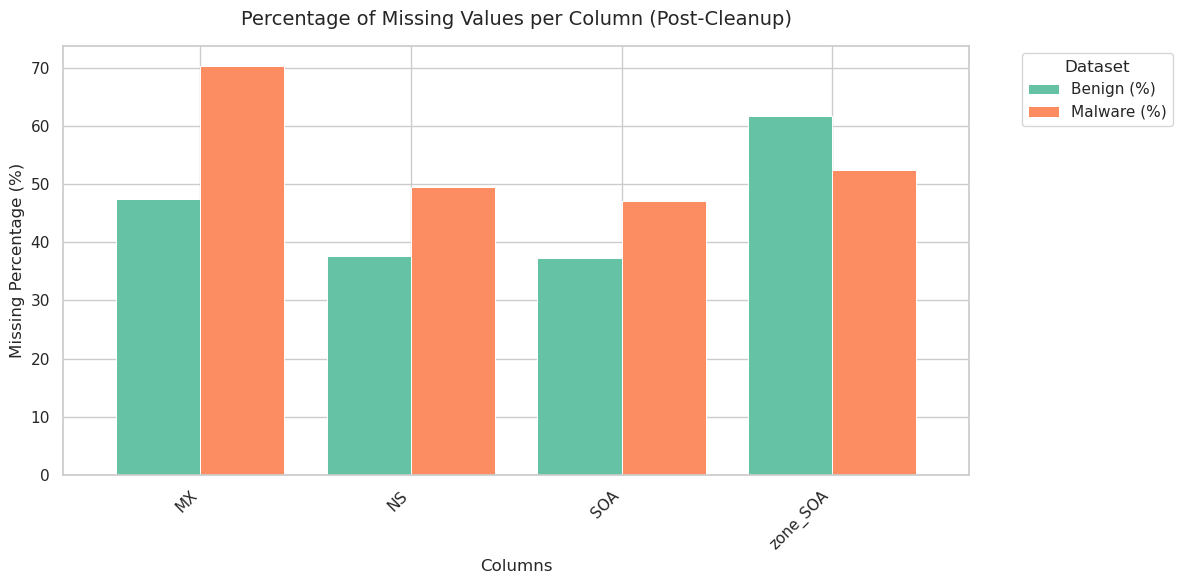

In [35]:
# Recalculate percentage of missing values after feature filtering
benign_missing_pct = benign_df.isna().mean() * 100
malware_missing_pct = malware_df.isna().mean() * 100

# Combine into a single DataFrame
missing_pct = pd.DataFrame({
    'Benign (%)': benign_missing_pct,
    'Malware (%)': malware_missing_pct
})

# Filter to only columns with any missing values
missing_pct = missing_pct[(missing_pct['Benign (%)'] > 0) | (missing_pct['Malware (%)'] > 0)]

# Plot updated missing value percentages
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))
colors = sns.color_palette("Set2", n_colors=2)

ax = missing_pct.plot(
    kind='bar',
    color=colors,
    width=0.8,
    linewidth=0.7,
    figsize=(12, 6)
)

ax.set_title("Percentage of Missing Values per Column (Post-Cleanup)", fontsize=14, pad=15)
ax.set_xlabel("Columns", fontsize=12)
ax.set_ylabel("Missing Percentage (%)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Prepare the dataframe for trasnformer training


In [36]:
# Convert NS field to a list of keys if it is stored as a dictionary
def extract_ns_keys(x):
    if isinstance(x, dict):
        return list(x.keys())
    return x

benign_df['NS'] = benign_df['NS'].apply(extract_ns_keys)
malware_df['NS'] = malware_df['NS'].apply(extract_ns_keys)


In [37]:
# Display current columns in the benign dataset
print("Benign dataset columns:")
print(benign_df.columns.to_list())


Benign dataset columns:
['domain_name', 'MX', 'NS', 'SOA', 'zone_SOA', 'remarks', 'ttls', 'label']


For training the transformer, it is necessary to create a one concatenated string with fields from analyzed dataframe

In [40]:
def prepare_input_string(row: pd.Series) -> str:
    """
    Convert a row of DNS metadata into a formatted input string for transformer models.
    Selected fields are joined using [SEP] tokens to retain field context.
    """
    CLS_TOKEN = "[CLS]"
    SEP_TOKEN = "[SEP]"
    tokens = []

    # Domain name
    domain = row.get("domain_name", "NA")
    if isinstance(domain, str):
        domain = domain.lower().lstrip("www.")
    tokens.append(f"domain: {domain}")

    # MX (dictionary keys)
    mx = row.get("MX")
    if isinstance(mx, dict):
        mx_keys = list(mx.keys())
        tokens.append(f"MX: {', '.join(mx_keys) if mx_keys else 'NA'}")
    else:
        tokens.append("MX: NA")

    # NS (list)
    ns = row.get("NS")
    if isinstance(ns, list) and ns:
        tokens.append(f"NS: {', '.join(ns)}")
    else:
        tokens.append("NS: NA")

    # SOA
    soa = row.get("SOA")
    if isinstance(soa, dict):
        primary_ns = soa.get("primary_ns", "NA")
        mailbox = soa.get("resp_mailbox_dname", "NA")
        tokens.append(f"SOA: primary_ns: {primary_ns} | resp_mailbox_dname: {mailbox}")
    else:
        tokens.append("SOA: NA")

    # zone_SOA
    zone_soa = row.get("zone_SOA")
    if isinstance(zone_soa, dict):
        primary_ns = zone_soa.get("primary_ns", "NA")
        mailbox = zone_soa.get("resp_mailbox_dname", "NA")
        tokens.append(f"zone_SOA: primary_ns: {primary_ns} | resp_mailbox_dname: {mailbox}")
    else:
        tokens.append("zone_SOA: NA")

    # Remarks
    remarks = row.get("remarks")
    if isinstance(remarks, dict):
        valid_pairs = [f"{k}: {v}" for k, v in remarks.items() if isinstance(v, str) and v.strip()]
        token = "remarks: " + " | ".join(valid_pairs) if valid_pairs else "remarks: NA"
        tokens.append(token)
    else:
        tokens.append("remarks: NA")

    return f"{CLS_TOKEN} " + f" {SEP_TOKEN} ".join(tokens) + f" {SEP_TOKEN}"

In [41]:
# Generate transformer input strings for each row
benign_df["input_string"] = benign_df.apply(prepare_input_string, axis=1)
malware_df["input_string"] = malware_df.apply(prepare_input_string, axis=1)

# Combine benign and malware data into a single dataset
combined_df = pd.concat(
    [benign_df[["input_string", "label"]], malware_df[["input_string", "label"]]],
    ignore_index=True
)

# Shuffle the combined dataset for training
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Preview the first few formatted records
print("Sample input strings with labels:")
print(combined_df.head())

Sample input strings with labels:
                                        input_string  label
0  [CLS] domain: obsproector.xyz [SEP] MX: NA [SE...      1
1  [CLS] domain: goldstartravel.pe [SEP] MX: mail...      1
2  [CLS] domain: dpab.org.bt [SEP] MX: mail.dpab....      0
3  [CLS] domain: rznvpetgwkjym.com [SEP] MX: NA [...      1
4  [CLS] domain: popost.top [SEP] MX: NA [SEP] NS...      1


In [ ]:
save_path = project_root / "datasets" / "malware" / "dns_malware_preprocessed.csv"
combined_df.to_csv(save_path, index=False)